### SEGAN without the GAN

In [5]:
import os
import torch
import re
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from data import SpeechDataset
import time
from another_model import Autoencoder
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq
import torch.nn.functional as F
import torchaudio
from tqdm.notebook import trange, tqdm
from IPython.display import Audio

In [6]:
torchaudio.set_audio_backend('sox_io')

In [7]:
if torch.backends.cudnn.enabled and torch.cuda.is_available():
    print('CUDA is ready!')

CUDA is ready!


In [8]:
num_epochs = 100
batch_size = 512
learning_rate = 2e-4

In [9]:
preload_model_from_weights = False
overfit_one_batch = True
limit_samples = batch_size if overfit_one_batch else 0

In [10]:
if preload_model_from_weights:
    epochs = filter(lambda x: re.search("^seae_epoch_\d+\.pth$", x), os.listdir('models'))
    epochs = map(lambda x: int(re.search("^seae_epoch_(\d+)\.pth$", x)[1]), epochs)
    last_epoch = max(epochs)
else:
    last_epoch = 0

In [11]:
if int(last_epoch) > 0: MODEL_PATH = f'models/seae_epoch_{last_epoch}.pth'

If you'd like to run the training loop, download the OpenSLR12 dataset (http://www.openslr.org/12/), convert all .flac files to .wav and copy to 'data/clean/open_slr'

In [12]:
dataset = SpeechDataset(clean_dir='data/clean/',
                        noise_dir='data/noise/', 
                        window_size=8192, 
                        overlap=50,
                        snr=5,
                        limit_samples=batch_size*3
                       )

In [13]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Weighted SDR loss adopted from: https://arxiv.org/pdf/1903.03107v1.pdf
The loss is bound [-1;1] 

In [10]:
def SDRLoss(output, target):
    output = output.view(-1, 16384)
    target = target.view(-1, 16384)
    
    return (-1 * torch.dot(output, target)) / (torch.norm(target) * torch.norm(output))

In [11]:
def weightedSDR(output, target, x):
    noise = x - target
    expected_noise = x - output 
    
    target_norm = torch.norm(target)
    target_norm_sq = target_norm * target_norm
    input_target_norm = torch.norm(x - target)
    input_target_norm_sq = input_target_norm * input_target_norm
    alpha = target_norm_sq / (target_norm_sq + input_target_norm_sq) 
    
    loss = alpha * SDRLoss(output, target) + (1 - alpha) * SDRLoss(noise, expected_noise)
    
    return loss

## The training

In [ ]:
model = Autoencoder(depth = 10, bs=batch_size, pay_attention=True).cuda()

if preload_model_from_weights:
    model.load_state_dict(torch.load(MODEL_PATH))
    last_epoch = 0
    
#criterion = weightedSDR
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

model.train()

pbar = tqdm()
pbar.reset(total=(len(dataset) // batch_size))
    
for epoch in trange(num_epochs):
    print_epoch = epoch % 5 == 0
    save_state = print_epoch
    
    if print_epoch: print(f'Starting epoch {epoch + 1 + last_epoch}')
    
    
    for i, data in enumerate(dataloader):
        inp = data[0].clone().detach().cuda()
        expected = data[1].clone().detach().cuda()
        output = model(inp)
        #loss = criterion(output, expected, inp)
        loss = criterion(output, expected)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #pbar.update()    
    
    pbar.refresh()
    if save_state:
        torch.save(model.state_dict(), f'models/noisy_seae_epoch_{epoch + last_epoch + 1}.pth')
    
    if print_epoch:
        print(f'epoch [{epoch}/{num_epochs}]')
        print(round(loss.item(), 5))

Starting epoch 1
epoch [0/100]
0.74251
Starting epoch 6
epoch [5/100]
0.14283
Starting epoch 11
epoch [10/100]
0.11677
Starting epoch 16
epoch [15/100]
0.10456
Starting epoch 21
epoch [20/100]
0.09471
Starting epoch 26
epoch [25/100]
0.08664


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

model.train()

pbar = tqdm()
pbar.reset(total=(len(dataset) // batch_size))
    
for epoch in trange(num_epochs):
    print_epoch = epoch % 10 == 0
    save_state = print_epoch
    
    if print_epoch: print(f'Starting epoch {epoch + 1 + last_epoch}')
    
    
    for i, data in enumerate(dataloader):
        inp = data[0].clone().detach().cuda()
        expected = data[1].clone().detach().cuda()
        output = model(inp)
        #loss = criterion(output, expected, inp)
        loss = criterion(output, expected)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #pbar.update()    
    
    pbar.refresh()
    if save_state:
        torch.save(model.state_dict(), f'models/second_noisy_seae_epoch_{epoch + last_epoch + 1}.pth')
    
    if print_epoch:
        print(f'epoch [{epoch}/{num_epochs}]')
        print(round(loss.item(), 5))

Starting epoch 1
epoch [0/100]
0.19773
Starting epoch 11
epoch [10/100]
0.19666
Starting epoch 21
epoch [20/100]
0.19674
Starting epoch 31
epoch [30/100]
0.19673
Starting epoch 41
epoch [40/100]
0.19657
Starting epoch 51
epoch [50/100]
0.19663
Starting epoch 61
epoch [60/100]
0.19652
Starting epoch 71
epoch [70/100]
0.19696
Starting epoch 81
epoch [80/100]
0.19684
Starting epoch 91
epoch [90/100]
0.19669



In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

model.train()

pbar = tqdm()
pbar.reset(total=(len(dataset) // batch_size))
    
for epoch in trange(num_epochs):
    print_epoch = epoch % 10 == 0
    save_state = print_epoch
    
    if print_epoch: print(f'Starting epoch {epoch + 1 + last_epoch}')
    
    
    for i, data in enumerate(dataloader):
        inp = data[0].clone().detach().cuda()
        expected = data[1].clone().detach().cuda()
        output = model(inp)
        #loss = criterion(output, expected, inp)
        loss = criterion(output, expected)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #pbar.update()    
    
    pbar.refresh()
    if save_state:
        torch.save(model.state_dict(), f'models/third_noisy_seae_epoch_{epoch + last_epoch + 1}.pth')
    
    if print_epoch:
        print(f'epoch [{epoch}/{num_epochs}]')
        print(round(loss.item(), 5))

Starting epoch 1
epoch [0/100]
0.19894
Starting epoch 11
epoch [10/100]
0.19676
Starting epoch 21
epoch [20/100]
0.19664
Starting epoch 31
epoch [30/100]
0.1966
Starting epoch 41
epoch [40/100]
0.19658
Starting epoch 51
epoch [50/100]
0.19671
Starting epoch 61
epoch [60/100]
0.19656
Starting epoch 71
epoch [70/100]
0.19653
Starting epoch 81
epoch [80/100]
0.19652
Starting epoch 91
epoch [90/100]
0.19651



## Looking (listening) to the results

In [18]:
pesqs = []

data = next(iter(dataloader))
model.eval()
with torch.no_grad():
    sample = data[1].cuda()
    inp = data[0]
    
    for i, _s in enumerate(sample[:5]):
        output = model(data[0].cuda())
        ref = output[i, :, :].cpu().detach().numpy().T[:, 0]
        target = sample[i, :, :].cpu().detach().numpy().T[:, 0]
        noised = inp[i, :, :].cpu().detach().numpy().T[:, 0]
        
        pesqs.append(pesq(target, ref, 16000))
        
print(round(sum(pesqs) / len(pesqs), 4))

2.1843


Target sound clip:

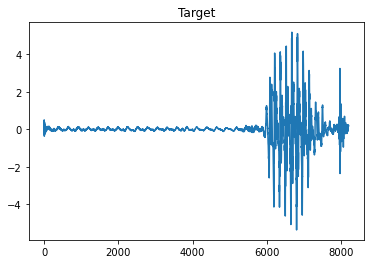

In [19]:
plt.figure()
plt.title('Target')
plt.plot(target)

Audio(target, rate=16000)

Reference sound clip:

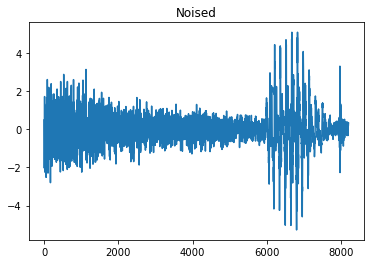

In [20]:
plt.figure()
plt.title('Noised')
plt.plot(noised)

Audio(noised, rate=16000)

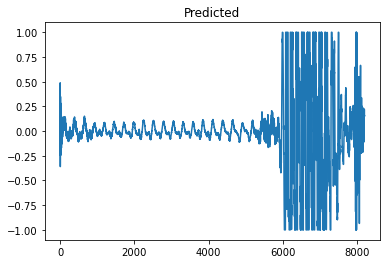

In [21]:
plt.figure()
plt.title('Predicted')
plt.plot(ref)

Audio(ref, rate=16000)

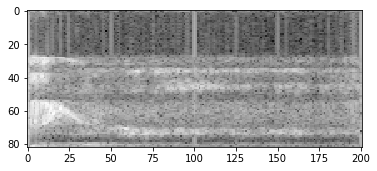

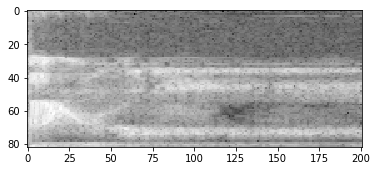

In [57]:
specgram = torchaudio.transforms.Spectrogram()(torch.tensor(ref).T)
plt.figure()
plt.imshow(specgram.T.log2().numpy())

specgram = torchaudio.transforms.Spectrogram()(torch.tensor(target).T)
plt.figure()
plt.imshow(specgram.T.log2().numpy())